<a href="https://colab.research.google.com/github/mengyu14/ANLY590/blob/master/tf_and_keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

#### first steps in TensorFlow

TensorFlow is a framework for automatic differentiation. It has an interface very similar to that of NumPy operating on array data. Let's start by rewriting our NumPy functions for a single neural net layer and a simple two-layer neural net in TensorFlow.

A few notes:
1. Instead of using `np.dot` for matrix multiplication, check out the `tf.matmul` function instead.
2. TensorFlow already has built-in functions for all of the common neural net activation functions with the exception of the "linear" activation function, which in TensorFlow is often thought of as having no activation function (since $f(x)=x$ does not change the input). We show you where to find these activation functions in the package and provide a simple implementation of the linear activation function.
3. notice that we are using a slightly different function signature for the neural network that lets us pack all of the parameters (weights and biases) into a list, as this will be convenient later when it comes to fitting the model.

In [ ]:
# activation functions
tf.nn.sigmoid
tf.nn.tanh
tf.nn.relu
linear = lambda x: x

def nn_layer(x, w, b, f):
    '''
    transformation for a single layer of a neural net

    x: array on inputs, shape: (batch size, input dim)
    w: array of weights, shape: (input dim, output dim)
    b: array of biases, shape: (output dim)
    f: activation function
    '''
    return f(tf.matmul(x, w) + b)

def nn_2layers(x, params, f_hidden, f_out):
    '''
    transformation for simple 2 layer neural net (hidden + output layers)

    x: array of inputs
    params: list of parameter arrays: [w_1, b_1, w_2, b_2]
    f_hidden: activation function on the hidden layer
    f_out: output function on the output layer
    '''
    h = nn_layer(x, params[0], params[1], f_hidden)
    yhat = nn_layer(h, params[2], params[3], f_out)
    return yhat

Here is a quick test to check if your code is working, at least for a simple case

In [ ]:
w1 = tf.ones((1, 10))
b1 = tf.zeros(10)
w2 = tf.ones((10, 1))
b2 = tf.ones(1)
x = 2 * tf.ones((1, 1))
yhat = nn_2layers(x, [w1, b1, w2, b2], linear, linear)
assert yhat.numpy().squeeze() == 21.

Now let's take a quick look at how TensorFlow can compute derivatives/gradients in a few simpler cases as we build up to using it to fit a neural network.

First let's do a simple function where we know the answer -- let's compute the derivative of $f(x) = x^2 + 5x$.

Do do this we the `tf.GradientTape()` object as a "context manager" where TensorFlow will track the computational graph of the calculation of $f(x)$ during the "forward pass". Then we can ask the tape to for the derivate of one of our values with respect to another, and it will be able to use the information that it stored to compute the "backward pass" to produce the desired result.

We will compute the gradient at $x = 1$, where we know the results should be:
$$
\begin{align}
f(1) &=  1^2 + 5 = 6 \\
f'(x) &= 2x+5 \\
f'(1) &= 2\cdot 1 + 5 = 7
\end{align}
$$

In [ ]:
x = tf.Variable(1.0)
with tf.GradientTape() as tape:
    f_x = x**2 + 5*x
print(f_x)
print(tape.gradient(f_x, x))

tf.Tensor(6.0, shape=(), dtype=float32)
tf.Tensor(7.0, shape=(), dtype=float32)


Now let's try something a little more challenging. Consider the function
$$
f(x, y) = \frac{e^x\cdot \sin{\sqrt{y + x^3}}}{\tanh{y}}
$$
Compute its gradient:
$$
\Big[\frac{\partial f}{\partial x}, \frac{\partial f}{\partial y}\Big]
$$
when $x = 1$, $y = 2$.

Look at the docs for `GradientTape.gradient` to figure out how to compute multiple derivatives at once.

In [ ]:
# your code here
x, y = tf.Variable(1.0), tf.Variable(2.0)
with tf.GradientTape() as tape:
    num = tf.exp(x)*tf.sin(tf.sqrt(y + x**3))
    dem = tf.nn.tanh(y)
    f = num / dem
    
print(f)
print(tape.gradient(f, [x, y]))

tf.Tensor(2.7831326, shape=(), dtype=float32)
[<tf.Tensor: shape=(), dtype=float32, numpy=2.3910627>, <tf.Tensor: shape=(), dtype=float32, numpy=-0.3346578>]


Now that you know how to compute gradients of any function, it's time to put this to use fitting a neural net. First, here is some synthetic nonlinear regression data to which we can fit our model.

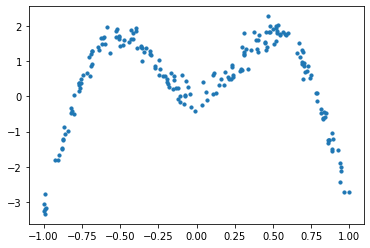

In [ ]:
n = 200
x = np.random.uniform(low=-1, high=1, size=n)
eps = 0.2 * np.random.randn(n)
y = 4 * x * np.sin(4 * x) + eps

x, y = x[:, np.newaxis].astype(np.float32), y[:, np.newaxis].astype(np.float32)

plt.scatter(x, y, s=10)
plt.show()

TensorFlow helps us compute gradients of functions. When fitting a neural net via gradient descent, the function that we want to take the gradient of is the loss function. So start by writting a function that compute the loss that we will use for our regression problem: mean squared error.

If you need to take an average (hint: you should probably be taking an average), checkout out the `tf.reduce_mean` fuction.

In [ ]:
def mse(y_true, y_pred):
    '''
    y_true: array of target values, shape: (batch size, 1)
    y_pred: array of predicted values, shape: (batch size, 1)
    '''
    return tf.reduce_mean((y_true - y_pred)**2)

Now let's write a function that does a single step of gradient descent. It should:
1. use a gradient tape to track computation
2. use `nn_2layers` to compute the prediction from the inputs
3. use the `mse` function to compute the loss from the predictions and the targets
4. use the gradient tape to compute the gradients
5. use the gradients and the step size to update the parameters

For updating the variable values, use the `assign()` method on any `Variable` rather than the usual Python assignment operator (`=`)

In [ ]:
def grad_step(x, y, params, f_hidden, f_out, step_size):
    '''
    updates `params` for a single step of gradient descent

    x: array of inputs, shape: (batch size, input dim)
    y: array of targets, shape: (batch size, 1)
    params: list of parameters (tf.Variables), [w1, b1, w2, b2]]
    f_hidden: activation function for the hidden layer
    f_out: activation function for the output layer
    step_size: gradient descent step size parameter

    returns: the loss
    '''
    with tf.GradientTape() as tape:
        yhat = nn_2layers(x, params, f_hidden, f_out)
        loss = mse(y, yhat)
        
    grads = tape.gradient(loss, params)
    for var, grad in zip(params, grads):
        var.assign(var - step_size * grad)
    
    return loss

Finally, let's put everything together to write a function that trains a neural net via gradient descent. Follow the following steps:
1. Generate random initial values for the parameters (check out `tf.random.uniform` and pick reasonable bounds)
2. Make `tf.Variable` values with these initial values
3. Use a loop to call your `grad_step` function repeatedly and save the loss values in a list as you go so you can return it at the end

We will assume that the input and targets are both 1-d, so the only thing we need to specify to know what shapes to use for the parameters is the number of units in the hidden layer.

In [ ]:
from tqdm.notebook import tqdm

def nn_grad_desc(x, y, n_hidden, f_hidden, f_out, step_size, n_iters):
    '''
    fit a two-layer neural net via gradient descent
    '''
    w1 = tf.random.uniform((1, n_hidden), minval=-1, maxval=1)
    b1 = tf.random.uniform((n_hidden,), minval=-1, maxval=1)

    w2 = tf.random.uniform((n_hidden, 1), minval=-1, maxval=1)
    b2 = tf.random.uniform((1,), minval=-1, maxval=1)

    params = [tf.Variable(p) for p in [w1, b1, w2, b2]]
    
    losses = []
    for i in tqdm(range(n_iters)):
        loss = grad_step(x, y, params, f_hidden, f_out, step_size)
        losses.append(loss)
    
    # return losses and final parameter values
    return losses, params

Now put all of your hard work to use! Call your function to fit the neural net and then plot your neural nets predictions against the data.

Some notes:
- Use the `tf.linspace` function to get a set of evenly spaced values to predict on for plotting
- Resuse your `nn_2layers` function to make predictions using the fitted parameters

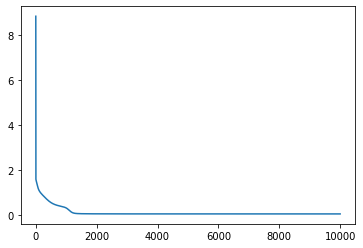

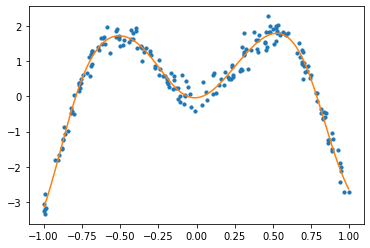

In [ ]:
# your code + plots here
losses, var = nn_grad_desc(x, y, n_hidden = 8, f_hidden = tf.nn.tanh, 
                            f_out = linear, step_size = 0.1, n_iters = 10000)

plt.plot(losses)
plt.show()

x_grid = tf.linspace(x.min(), x.max(), 200)[:, tf.newaxis]
yhat = nn_2layers(x_grid, var, tf.nn.tanh, linear)

plt.scatter(x, y, s=10)
plt.plot([], [])
plt.plot(x_grid, yhat)
plt.show()

In [12]:
from tensorflow import keras as tfk

model = tfk.Sequential([
  tfk.layers.InputLayer((1,)),
  tfk.layers.Dense(8, activation = tf.nn.tanh),
  tfk.layers.Dense(1, activation = None)
])

model.summary()

loss = tfk.losses.MeanSquaredError()
opt = tfk.optimizers.Adam()
model.compile(opt, loss)

results = model.fit(x, y, epochs = 10000, batch_size = x.shape[0], verbose = 0) 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 16        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 25
Trainable params: 25
Non-trainable params: 0
_________________________________________________________________


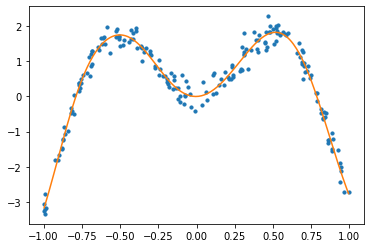

In [13]:
yhat = model(x_grid)

plt.scatter(x, y, s=10)
plt.plot([], [])
plt.plot(x_grid, yhat)
plt.show()